In [1]:
import os, re
from os.path import isdir, join, exists, abspath, isfile
import numpy as np
import matplotlib.pyplot as plt
from subprocess import call
from wordsegment import segment, clean
from nltk.stem import SnowballStemmer
%matplotlib notebook

# Load documents and scrutinize unwanted punctuations
**Load document labels**

In [2]:
raw_path = u'./corpus/raw-docs' # it will listdir into unicode
doc_labels = [fn for fn in os.listdir(raw_path) if isdir(join(raw_path, fn))] # list only folders
print 'Showing one sample document label'
print 'Unicode codepoints representation:', repr(doc_labels[0]), '::', type(doc_labels[0])
print 'The actual glyph (appearance):', doc_labels[0]

Showing one sample document label
Unicode codepoints representation: u'\u0e1a\u0e23\u0e34\u0e2b\u0e32\u0e23\u0e18\u0e38\u0e23\u0e01\u0e34\u0e08' :: <type 'unicode'>
The actual glyph (appearance): บริหารธุรกิจ


**Show all document labels**

In [3]:
doc_labels_idx = {} # maps label name to its corresponding index
print 'Total labels:', len(doc_labels)
for i, label in enumerate(doc_labels):
    doc_labels_idx[label] = i
    print "%d: %s" % (i, label)

Total labels: 20
0: บริหารธุรกิจ
1: ประมง
2: มนุษยศาสตร์
3: วนศาสตร์
4: วิทยาการจัดการ
5: วิทยาศาสตร์
6: วิทยาศาสตร์การกีฬา
7: วิศวกรรมศาสตร์
8: ศิลปศาสตร์และวิทยาศาสตร์
9: ศึกษาศาสตร์
10: ศึกษาศาสตร์และพัฒนศาสตร์
11: สถาปัตยกรรมศาสตร์
12: สังคมศาสตร์
13: สัตวแพทยศาสตร์
14: สิ่งแวดล้อม
15: อุตสาหกรรมเกษตร
16: เกษตร
17: เศรษฐศาสตร์
18: โครงการจัดตั้งวิทยาเขตสุพรรณบุรี
19: โครงการสหวิทยาการระดับบัณฑิตศึกษา


**Open documents from each folder**

In [14]:
%%time
label_freqs = []
dataset_contents, dataset_labels, dataset_filenames, content_lengths = [], [], [], [] # will be used later
for i, label in enumerate(doc_labels):
    curr_dir = join(raw_path, label)
    fns = os.listdir(curr_dir)
#     print len(fns), label
    label_freqs.append(len(fns))
    for fn in fns:
        file_path = join(curr_dir, fn)
        with open(file_path, 'r') as f:
            content = unicode(f.read(), 'utf8')
            content_lengths.append(len(content))
            dataset_contents.append(content)
            dataset_labels.append(i)
            dataset_filenames.append(fn)

Wall time: 50.6 s



**Show number of files in each folder**

<IPython.core.display.Javascript object>


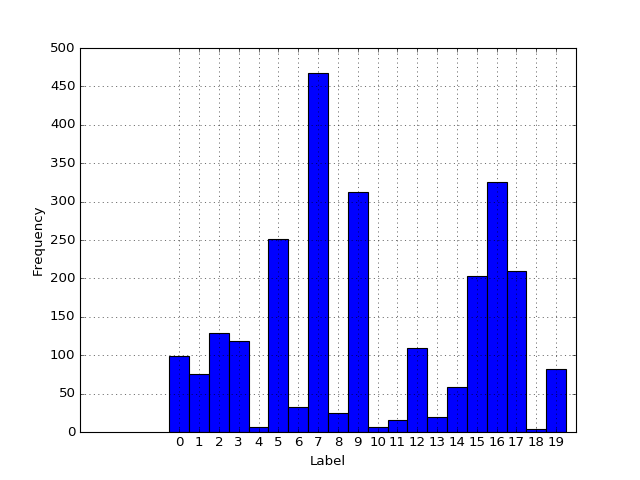

In [5]:
plt.figure()
plt.bar(np.arange(len(doc_labels))-0.5, label_freqs, 1)
plt.xticks(np.arange(len(doc_labels)))
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.yticks(np.arange(0, max(label_freqs)+50, 50))
plt.grid()
plt.show()

**Show dataset statistics**

In [6]:
print 'Total documents:', len(dataset_contents)
print 'Label Frequencies:', label_freqs
print 'Label Frequencies Mean:', np.mean(label_freqs)
print 'Content Lengths Mean:', np.mean(content_lengths)

Total documents: 2549
Label Frequencies: [99, 76, 129, 119, 6, 251, 32, 468, 25, 312, 6, 15, 110, 19, 58, 203, 326, 209, 4, 82]
Label Frequencies Mean: 127.45
Content Lengths Mean: 189040.900353


**Remove outliers**

In [7]:
# idx = np.argmax(content_lengths)
# del content_lengths[idx]
# del dataset_contents[idx]
# del dataset_labels[idx]
# del dataset_filenames[idx]

**Show histogram of all contents' length**

<IPython.core.display.Javascript object>


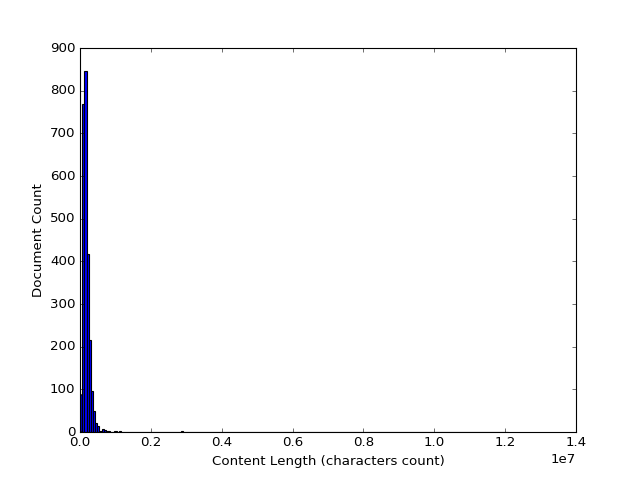

In [8]:
plt.figure()
plt.hist(content_lengths, bins=200)
plt.xlabel('Content Length (characters count)')
plt.ylabel('Document Count')
plt.show()

In [9]:
def has_thai_char(s):
    return any(u'\u0e00' < c < u'\u0f00' for c in s)
print has_thai_char(u'สวัสดีจ้ะ english')
print has_thai_char(u'Ianalysis')

True
False


## Scrutinize unwanted punctuations
**Define scrutinize() function**

In [18]:
punctuations = set(u'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
stemmer = SnowballStemmer('english')
limit = 70
def scrutinize(s):
    scrutinized = u''.join(u' ' if c in punctuations else c for c in s) # remove all punctuations inside s
    segmented = []
    for sentence in scrutinized.split(): # split contiguous english words if possible
        if not has_thai_char(sentence):
            sentence = clean(sentence)
            try:
                if len(sentence) > limit:
                    raise ValueError('too long to segment len > %d' % limit)
                sentence = u' '.join(stemmer.stem(word) for word in segment(sentence))
            except Exception, e:
                print 'skip (len=%d, word=%s..., exception=%s)' % (len(sentence), sentence[:50], str(e))
                sentence = None
        if sentence:
            segmented.append(sentence)
    return u' '.join(segmented)

**Sample Original Content**

In [11]:
sample = dataset_contents[3][:2**9]
print sample
# sample

I50731645
Iวิทยานิพนธ์
Iการพัฒนาประสิทธิผลในการทางานของผู้ทาบัญชี
Iหลังจากเข้ารับการพัฒนาความรู้ต่อเนื่องทางวิชาชีพ
Ieffectiveness development in practicing
Iof bookkeepers after attending
Icontinuing professional development
Iนางสาวสุภาพันธุ์ สายทองอินทร์
Iบัณฑิตวิทยาลัย มหาวิทยาลัยเกษตรศาสตร์
Iพ . ศ . 2554
Iใบรับรองวิทยานิพนธ์
Iบัณฑิตวิทยาลัย มหาวิทยาลัยเกษตรศาสตร์
Iบริหารธุรกิจมหาบัณฑิต
Iปริญญา
Iสาขา
Iภาควิชา
Iเรื่อง 
Iการพัฒนาประสิทธิผลในการทางานของผู้ทาบัญชี หลังจากเข้ารับ
Iการพัฒนาความรู้ต่อเนื่องทางว


**Sample Content Scrutinized**

In [19]:
scrutinized = scrutinize(sample)
print scrutinized
# scrutinized

i50731645 Iวิทยานิพนธ์ Iการพัฒนาประสิทธิผลในการทางานของผู้ทาบัญชี Iหลังจากเข้ารับการพัฒนาความรู้ต่อเนื่องทางวิชาชีพ i effect develop in practic iof bookkeep after attend i continu profession develop Iนางสาวสุภาพันธุ์ สายทองอินทร์ Iบัณฑิตวิทยาลัย มหาวิทยาลัยเกษตรศาสตร์ Iพ ศ 2554 Iใบรับรองวิทยานิพนธ์ Iบัณฑิตวิทยาลัย มหาวิทยาลัยเกษตรศาสตร์ Iบริหารธุรกิจมหาบัณฑิต Iปริญญา Iสาขา Iภาควิชา Iเรื่อง Iการพัฒนาประสิทธิผลในการทางานของผู้ทาบัญชี หลังจากเข้ารับ Iการพัฒนาความรู้ต่อเนื่องทางว


**Scrutinize all contents**

In [20]:
%%time
for i in xrange(len(dataset_contents)):
    print i,
    dataset_contents[i] = scrutinize(dataset_contents[i])
    content_lengths[i] = len(dataset_contents[i])
print 'New Content Lengths Mean:', np.mean(content_lengths)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

**New Content Lengths after Scrutinizing**

<IPython.core.display.Javascript object>


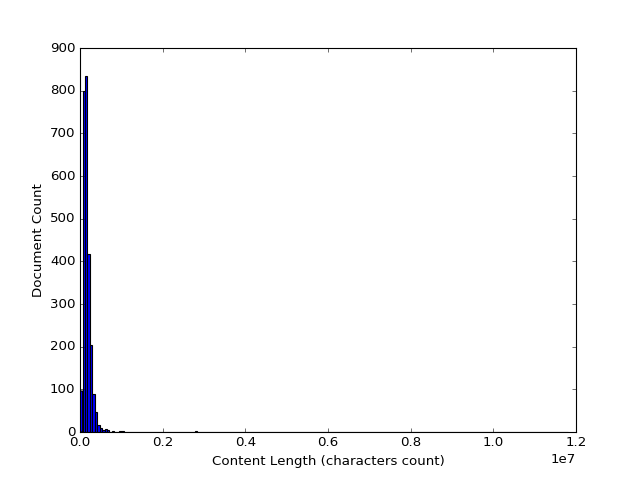

In [21]:
plt.figure()
plt.hist(content_lengths, bins=200)
plt.xlabel('Content Length (characters count)')
plt.ylabel('Document Count')
plt.show()

**Save scrutinized contents**

In [22]:
%%time
scrutinized_path = './corpus/scrutinized-docs'
for content, label, fn in zip(dataset_contents, dataset_labels, dataset_filenames):
    str_label = doc_labels[label]
    folder_path = join(scrutinized_path, str_label)
    if not exists(folder_path):
        os.makedirs(folder_path)
    file_path = join(folder_path, fn)
    with open(file_path, 'w') as f:
        f.write(content.encode('utf8'))
del dataset_contents

Wall time: 1min 21s


# Segment each document and save them
**Create new folders if necessary**

In [23]:
segmented_path = u'./corpus/segmented-docs'
for label in doc_labels:
    folder_path = join(segmented_path, label)
    if not exists(folder_path):
        os.makedirs(folder_path)
        print 'New folder', folder_path

New folder ./corpus/segmented-docs\บริหารธุรกิจ
New folder ./corpus/segmented-docs\ประมง
New folder ./corpus/segmented-docs\มนุษยศาสตร์
New folder ./corpus/segmented-docs\วนศาสตร์
New folder ./corpus/segmented-docs\วิทยาการจัดการ
New folder ./corpus/segmented-docs\วิทยาศาสตร์
New folder ./corpus/segmented-docs\วิทยาศาสตร์การกีฬา
New folder ./corpus/segmented-docs\วิศวกรรมศาสตร์
New folder ./corpus/segmented-docs\ศิลปศาสตร์และวิทยาศาสตร์
New folder ./corpus/segmented-docs\ศึกษาศาสตร์
New folder ./corpus/segmented-docs\ศึกษาศาสตร์และพัฒนศาสตร์
New folder ./corpus/segmented-docs\สถาปัตยกรรมศาสตร์
New folder ./corpus/segmented-docs\สังคมศาสตร์
New folder ./corpus/segmented-docs\สัตวแพทยศาสตร์
New folder ./corpus/segmented-docs\สิ่งแวดล้อม
New folder ./corpus/segmented-docs\อุตสาหกรรมเกษตร
New folder ./corpus/segmented-docs\เกษตร
New folder ./corpus/segmented-docs\เศรษฐศาสตร์
New folder ./corpus/segmented-docs\โครงการจัดตั้งวิทยาเขตสุพรรณบุรี
New folder ./corpus/segmented-docs\โครงการสหวิทย

** Create temporary paths file then call Java LongLexTo on that file to segment all documents**

In [24]:
%%time
try:
    os.chdir('LongLexTo')
except:
    pass
print os.getcwdu()
tmp_paths = u'tmp_paths.txt'
tmp_output = u'tmp_output.txt'
with open(tmp_paths, 'w') as f:
    contents = []
    for label, fn in zip(dataset_labels, dataset_filenames):
        str_label = doc_labels[label]
        ifp = join('..', scrutinized_path, str_label, fn) # input file path
        ofp = join('..', segmented_path, str_label, fn) # output file path
        if not isfile(ifp):
            print 'Error:', ifp, ofp
            raise AssertionError('input file path is invalid')
        content = ifp + u'\n' + ofp + u'\n'
        contents.append(content)
    content = u'q\n'
    contents.append(content)
    f.write(''.join(contents).encode('utf8'))
print 'Running...'
return_code = call(u'java LongLexTo -Dfile.encoding=UTF-8 < %s > %s' % (tmp_paths, tmp_output), shell=True)
print 'return code:', return_code
print 'Please see %s and %s for more info' % (tmp_paths, tmp_output)
if return_code:
    print 'You may need to call the Java commmand yourself because I failed'
    print 'The paths creation process was successful but the segmentation went wrong'
    print 'Go into the folder LongLexTo, open a shell then type the following command'
    print 'java -Dfile.encoding=UTF-8 LongLexTo < tmp_paths.txt'
    print 'Wait a minute and go check at the segmented-docs folder to see if the segmentation went right.'
    print 'The file will be encoded in UTF-8 and there will be no punctuations in each file.'
os.chdir('..')

D:\off99555\Documents\GitHub\Thai-thesis-classification\LongLexTo
Running...
return code: 1
Please see tmp_paths.txt and tmp_output.txt for more info
You may need to call the Java commmand yourself because I failed
The paths creation process was successful but the segmentation went wrong
Go into the folder LongLexTo, open a shell then type the following command
java -Dfile.encoding=UTF-8 LongLexTo < tmp_paths.txt
Wait a minute and go check at the segmented-docs folder to see if the segmentation went right.
The file will be encoded in UTF-8 and there will be no punctuations in each file.
Wall time: 1.94 s
